# Hello Face Detection

A very basic introduction to using face detection models with OpenVINO™ 

The [Model/face-detection-adas-0001](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/face-detection-adas-0001/README.md) model from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used. It detects faces in images and returns a blob of data 

with shape: `1, 1, 200, 7` in the format `1, 1, N, 7`, where `N` is the number of detected
bounding boxes. The results are sorted by confidence in decreasing order. Each detection has the format
[`image_id`, `label`, `conf`, `x_min`, `y_min`, `x_max`, `y_max`], where:

- `image_id` - ID of the image in the batch
- `label` - predicted class ID (1 - face)
- `conf` - confidence for the predicted class
- (`x_min`, `y_min`) - coordinates of the top left bounding box corner
- (`x_max`, `y_max`) - coordinates of the bottom right bounding box corner

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

In [5]:
ie = Core()

model = ie.read_model(model='models/face-detection-adas-0001.xml')
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output(0)

#input_layer_ir

## Load the Model

###  model details could be found here:
https://docs.openvino.ai/latest/omz_models_model_face_detection_adas_0001.html#doxid-omz-models-model-face-detection-adas-0001

## Load an Image

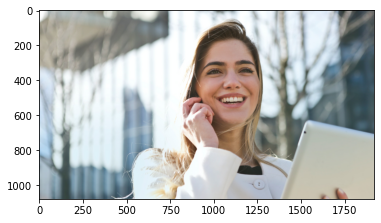

In [6]:
image = cv2.imread("data/1-face.jpg")
height,width=image.shape[0:2]

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer_ir.shape

# Resize the image to meet network input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

## Do Inference

In [8]:
THRESH=0.1

# Create an inference request.
boxes = compiled_model([input_image])[output_layer_ir]

#finding the boxes with high enough score
boxes=boxes.squeeze()[:,-5:]
boxes=np.array([x[-4:] for x in boxes if x[0]>THRESH])   #take only boxes that confidence>THRESH

#scaling cordinates back to original size
boxes=boxes*np.array([width,height,width,height])

boxes=boxes.astype(np.int64)

#boxes

## Visualize Results

In [9]:
def draw(image,boxes):
    new_image=image.copy()
    color = (0,200,0)
    for box in boxes:
        x1,y1,x2,y2=box
        cv2.rectangle(img=new_image, pt1=(x1,y1), pt2=(x2, y2), color=color, thickness=10)
    return new_image

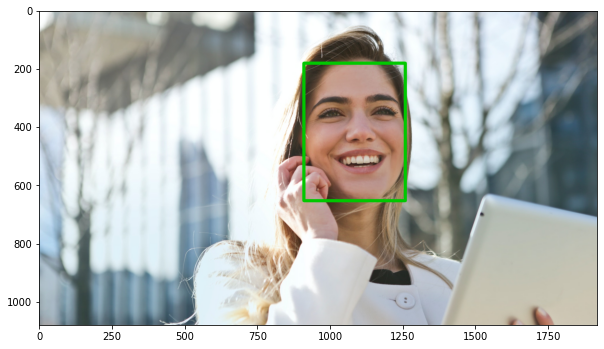

In [10]:
plt.figure(figsize=(10, 6))
final_image=draw(image, boxes)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))